In [1]:
import discretisedfield as df
import numpy as np

## 1. Setup

In [2]:
import micromagneticmodel as mm

In [3]:
#system = mm.System(name='spinchain')

## 2. Primary spin chain

In [4]:
spinchain_name = 'primary_spinchain'

### 2.1. Energy equation

In [5]:
spinchain_energy_terms = []

#### 2.1.1. Static zeeman energy

In [6]:
spinchain_H0 = (0, 0, 0.1/mm.consts.mu0) # Zeeman energy (A/m)
spinchain_energy_terms.append(mm.Zeeman(H=spinchain_H0, 
                                        name='zeeman_static'))

#### 2.1.1. Dynamic zeeman energy

In [7]:
spinchain_h0 = (3e-3/mm.consts.mu0, 0, 0)
spinchain_freq = 15e9  # driving frequency (Hz)
spinchain_timeshift = 1e-9  # time shift, t - t0, (s)

spinchain_energy_terms.append(mm.Zeeman(H=spinchain_h0, 
                                        name='zeeman_dynamic',
                                        func='sin',
                                        f=spinchain_freq,
                                        t0=spinchain_timeshift))

#### 2.1.2. Heisenberg exchange energy

In [8]:
spinchain_A = 1.6e-11  # exchange interaction energy (J/m)
# A = 0.5 * mm.consts.mu0 * Ms**2 * lex**2
spinchain_energy_terms.append(mm.Exchange(A=spinchain_A))

#### 2.1.3. Dzyaloshinskii-Moriya energy

In [9]:
spinchain_crystalclass = 'T'  # see documentation for list (https://ubermag.github.io/api/_autosummary/micromagneticmodel.DMI.html)
spinchain_Dij = 1.5e-3  # microscopic DM interaction constant (J/m^2)

In [10]:
spinchain_dmi_term = mm.DMI(D=spinchain_Dij, crystalclass=spinchain_crystalclass)

In [11]:
spinchain_dmi_term

DMI(D=0.0015, crystalclass='T')

In [12]:
#spinchain_energy_terms.append(spinchain_dmi_term)

#### 2.1.4. Demagnetisation energy

In [13]:
spinchain_energy_terms.append(mm.Demag())

#### 2. Hamiltonian

In [14]:
spinchain_energy =  mm.Energy(terms=spinchain_energy_terms)

In [15]:
print(f'This energy equation has {len(spinchain_energy)} terms, and is given by: ', end='')

This energy equation has 4 terms, and is given by: 

In [16]:
spinchain_energy

Zeeman(H=(0, 0, 79577.47154594767)) + Zeeman(H=(2387.32414637843, 0, 0), f=15000000000.0, t0=1e-09, func='sin') + Exchange(A=1.6e-11) + Demag()

### 2.2. Magnetisation field

#### 2.2.1. Region

In [17]:
spinchain_region_p1 = (0, 0, 0)  # point1 (nm)
spinchain_region_p2 = (20e-9, 1e-9, 1e-9)  # point 2 (nm)

spinchain_region = df.Region(p1=spinchain_region_p1, p2=spinchain_region_p2)

#### 2.2.2. Mesh

In [18]:
spinchain_mesh_cell_size = (1e-9, 1e-9, 1e-9)

# spinchain_mesh = df.Mesh(region=spinchain_region, n=(128, 1, 1))
spinchain_mesh = df.Mesh(region=spinchain_region, cell=spinchain_mesh_cell_size)

In [19]:
print(f'Spinchain mesh (Num. discretised cells)\n'
      f'----------------\n'
      f' - X: {spinchain_mesh.n[0]}\n'
      f' - Y: {spinchain_mesh.n[1]}\n'
      f' - Z: {spinchain_mesh.n[2]}\n'
      f'----------------\n'
      f' - Total: {len(spinchain_mesh)}\n')

Spinchain mesh (Num. discretised cells)
----------------
 - X: 20
 - Y: 1
 - Z: 1
----------------
 - Total: 20



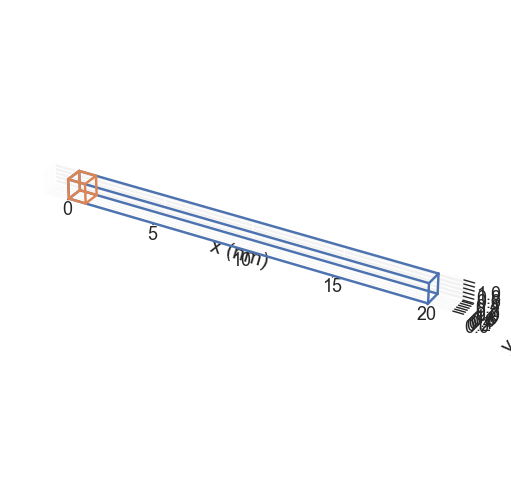

In [20]:
spinchain_mesh.mpl()

#### 2.2.3. Field

In [21]:
spinchain_field_m_init = (1, 0, 0)
Ms  = 800e3  # saturisation magnetisation (A/m)
spinchain_num_dims = 3

spinchain_magnetisation_field = df.Field(mesh=spinchain_mesh, 
                                         nvdim=spinchain_num_dims, 
                                         value=spinchain_field_m_init, 
                                         norm=Ms)

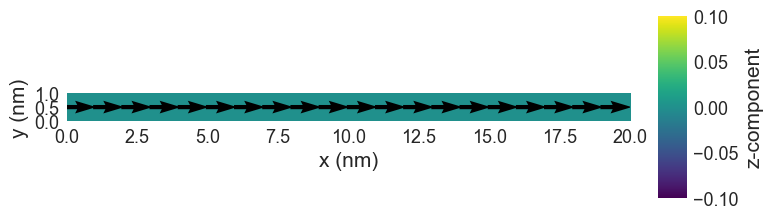

In [22]:
spinchain_magnetisation_field.sel('z').mpl()

### 2.3. Dynamics equations

In [23]:
spinchain_dynamics_terms = []

#### 2.3.1. Precession term

In [24]:
spinchain_gamma = 2 * np.pi * 29.2e9 * mm.consts.mu0  # gyrotropic ratio (A s / kg) i.e. (C/kg)
spinchain_gamm0 = spinchain_gamma * mm.consts.mu0  # gyromagnetic ratio (m / As)

spinchain_precession = mm.Precession(gamma0=spinchain_gamm0)

spinchain_dynamics_terms.append(spinchain_precession)

#### 2.3.2. Damping term

In [25]:
spinchain_alpha = 1e-4

spinchain_dynamics_terms.append(mm.Damping(alpha=spinchain_alpha))

#### 2.3.3. Dynamics equation

In [26]:
spinchain_dynamics = mm.Dynamics(terms=spinchain_dynamics_terms) 

In [27]:
print(f'This dynamics equation has {len(spinchain_dynamics)} terms, and is given by: ', end='')

This dynamics equation has 2 terms, and is given by: 

In [28]:
spinchain_dynamics

Precession(gamma0=0.2897226493007215) + Damping(alpha=0.0001)

### 2.4. Construct system

In [29]:
spinchain_system = mm.System(name=spinchain_name,
                             energy=spinchain_energy,
                             dynamics=spinchain_dynamics,
                             m=spinchain_magnetisation_field
                            )

## 3. Driving region

## 4. Drivers

In [30]:
import oommfc as oc

### 4.1. Minimise energy

#### 4.1.1. Create driver

In [31]:
mindriver = oc.MinDriver()

#### 4.1.2. Run driver to minimise energy

In [32]:
mindriver.drive(spinchain_system)

Running OOMMF (TclOOMMFRunner)[2024/05/16 19:21]... (9.3 s)


RuntimeError: Error in OOMMF run.
command: tclsh C:\Users\Cameron McEleney\oommf\oommf.tcl boxsi +fg primary_spinchain.mif -exitondone 1


#### 4.1.3. Check output (model)

In [ ]:
spinchain_system.m.sel('z').mpl()

#### 4.1.4. Check output (line plot)

In [ ]:
line = spinchain_system.m.line(p1=spinchain_system.m.mesh.region.pmin, p2=spinchain_system.m.mesh.region.pmax, n=19)
line.mpl(marker='o')

### 4.2. Dynamic drive

#### 4.2.1. Create driver (TimeDriver)

In [ ]:
spinchain_timedriver = oc.TimeDriver()

#### 4.2.2. Run driver

In [ ]:
spinchain_time_max = 5e-9  # maximum simulated time (s)
spinchain_num_steps = 200  # number of steps during simulation

print(f'Stepsize, h: {spinchain_time_max/spinchain_num_steps} (s)')

spinchain_timedriver.drive(spinchain_system, 
                           t=spinchain_time_max,
                           n=spinchain_num_steps)

#### 4.2.3. Plot data (table)

In [ ]:
spinchain_system.table.data

#### 4.2.4. Plot data (graph)

In [ ]:
spinchain_system.table.mpl(y=['mx', 'my', 'mz'])